# Axial Braiding

In [190]:
import numpy as np
from matplotlib import pyplot as  plt
import scipy as sc
from scipy import special as sp
import cmath as cmp
from matplotlib import cm
%matplotlib notebook

#define global parameters for Airy function
C = 1
r_0 = 5*10**-4 #0.5 mm
a = 0.2
s = 1.2*10**-4 #0.12 mm
#other parameters
wavelength = 1.064*10**-6 #1064 nm
k_0 = 2*np.pi/wavelength

def airy(x,y,z):
    #obtain field of Airy field at any position
    r = np.sqrt(x**2 + y**2)
    x0 = (r_0 - r)/s
    xi = z/(k_0 * s**2)
    g = sp.airy(x0 - (xi**2)/4 + 1j*a*xi)[0] * np.exp(a*x0 - a*(xi**2)/2) * np.exp(1j*(x0*xi/2 + a**2*(xi)/2 - xi**3/12))
    #print focusing length found:
    z_f = 2*k_0*(s**2)*np.sqrt(r_0/s + 1.018 - (a**2)) #0.385m
    u_CAB = C * g * np.exp(1j*k_0*z)
    return u_CAB
    
def Airy_transverse_map(z):
    #plot landscape of Airy intensity at any z
    xmax = 1*10**-3
    dx = 1*10**-5
    xlist, ylist = np.arange(-xmax, xmax, dx), np.arange(-xmax, xmax, dx)
    size = int(2*xmax/dx)
    I_CAB_z_array = np.zeros((size, size))
    z_f = 2*k_0*(s**2)*np.sqrt(r_0/s + 1.018 - (a**2))
    for row in range(len(I_CAB_z_array)):
        for col in range(len(I_CAB_z_array)):
            x, y = xlist[row], ylist[col]
            intensity = np.real(airy(x,y,z))**2 + np.imag(airy(x,y,z))**2
            I_CAB_z_array[row][col] = intensity
    plt.figure()
    plt.xlabel('x (10 microns)') #1 px = 10 microns
    plt.ylabel('y (10 microns)')
    plt.imshow(I_CAB_z_array, cmap = 'gray', interpolation = 'nearest')
    plt.colorbar()
    return

def bessel(x,y,z):
    #obtain bessel field at any location
    #the parameters A, theta, l are set by the experimenters:
    A, theta, l = 1, 0.005, 2 #5, 8 mrad were used for theta
    #obtain intensity of bessel field at any point
    r = np.sqrt(x**2 + y**2)
    if x == 0:
        phi = (np.pi)/2
    else:
        phi = np.arctan(y/x)
    u_B = A * sp.jv(l,k_0*np.sin(theta)*r) * np.exp(1j*(l*phi + k_0*np.cos(theta)*z)) #Bessel function always goes to 0 as arg goes to 0, unless l=0
    return u_B

def Bessel_transverse_map(z):
    #plot landscape of Bessel intensity at any z
    xmax = 1*10**-3
    dx = 1*10**-5
    xlist, ylist = np.arange(-xmax, xmax, dx), np.arange(-xmax, xmax, dx)
    size = int(2*xmax/dx)
    I_Bessel_z_array = np.zeros((size, size))
    for row in range(len(I_Bessel_z_array)):
        for col in range(len(I_Bessel_z_array)):
            x, y = xlist[row], ylist[col]
            intensity = np.real(bessel(x,y,z))**2 + np.imag(bessel(x,y,z))**2  
            I_Bessel_z_array[row][col] = intensity
    plt.figure()
    plt.xlabel('x (10 microns)') #1 px = 10 microns
    plt.ylabel('y (10 microns)')
    plt.imshow(I_Bessel_z_array, cmap = 'gray', interpolation = 'nearest')
    plt.colorbar()
    return

def x_z_braiding(y, A, theta, l):
    #plot an x-z cut of the superposed fields
    xmax, zmax = 1*10**-3, 1.0
    dx, dz = 1*10**-5, 1*10**-3
    xlist = np.arange(-xmax, xmax, dx)
    zlist = np.arange(0, zmax, dz)
    intensity_array = np.zeros((len(zlist), len(xlist)))
    for zindex in range(len(zlist)): #rows are y-axis -> z
        for xindex in range(len(xlist)): #cols are x-axis
            x = xlist[xindex]
            z = zlist[zindex]
            r = np.sqrt(x**2 + y**2)
            if x == 0:
                phi = (np.pi)/2
            else:
                phi = np.arctan(y/x)
            u_B = A * sp.jv(l,k_0*np.sin(theta)*r) * np.exp(1j*(l*phi + k_0*np.cos(theta)*z))
            field = u_B + airy(x,y,z) #superposed
            I = np.imag(field)**2 + np.real(field)**2
            intensity_array[zindex][xindex] = I
    plt.figure(figsize=(12,6))
    plt.xlabel('x')
    plt.ylabel('z')
    plt.imshow(intensity_array, cmap = 'rainbow', interpolation = 'nearest')
    plt.colorbar()
    return

def my_int(x,y,z, A, theta, l):
    r = np.sqrt(x**2 + y**2)
    if x.any() == 0:
        phi = (np.pi)/2
    else:
        phi = np.arctan(y/x)
    u_B = A * sp.jv(l,k_0*np.sin(theta)*r) * np.exp(1j*(l*phi + k_0*np.cos(theta)*z))
    field = u_B + airy(x,y,z) #superposed
    return np.imag(field)**2 + np.real(field)**2

def x_z_braiding_3D(y, A, theta, l):
    #a 3D, rotatable plot of intensity at any y
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    xmax, zmax = 1*10**-3, 0.7
    dx, dz = 1*10**-5, 1*10**-2
    X = np.arange(-xmax, xmax, dx)
    Z = np.arange(0, zmax, dz)
    X,Z = np.meshgrid(X,Z)
    I = my_int(X,y,Z,A,theta,l)
    surf = ax.plot_surface(X, Z, I, cmap = cm.rainbow, linewidth=0, antialiased=False) #change I to F for force
    ax.set_xlabel('x (m)')
    ax.set_ylabel('z (m)')
    ax.set_zlabel('Intensity')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

def x_y_map(z, A, theta, l):
    #intensity profiles of superposed beams in x-y
    xmax = 0.5*10**-3
    dx = 1*10**-5
    xlist, ylist = np.arange(-xmax, xmax, dx), np.arange(-xmax, xmax, dx)
    size = int(2*xmax/dx)
    int_array = np.zeros((size, size))
    for row in range(len(int_array)):
        for col in range(len(int_array)):
            x, y = xlist[row], ylist[col]
            r = np.sqrt(x**2 + y**2)
            if x == 0:
                phi = (np.pi)/2
            else:
                phi = np.arctan(y/x)
            u_B = A * sp.jv(l,k_0*np.sin(theta)*r) * np.exp(1j*(l*phi + k_0*np.cos(theta)*z)) 
            field = u_B + airy(x,y,z)
            intensity = np.imag(field)**2 + np.real(field)**2
            int_array[row][col] = intensity
    plt.figure()
    plt.xlabel('x') #1 px = 10 microns
    plt.ylabel('y')
    plt.imshow(int_array, cmap = 'rainbow', interpolation = 'nearest')
    plt.colorbar()
    return

def bessel_superpositions(x,y,z,l_1, l_2):
    theta_1, theta_2 = 0.008, 0.009
    A_1, A_2 = 1, 1
    #if x == 0:
    if x.all() == 0:
        phi = (np.pi)/2
    else:
        phi = np.arctan(y/x)
    r = np.sqrt(x**2 + y**2)
    u_B_1 = A_1 * sp.jv(l_1,k_0*np.sin(theta_1)*r) * np.exp(1j*(l_1*phi + k_0*np.cos(theta_1)*z)) #first bessel function
    u_B_2 = A_2 * sp.jv(l_2,k_0*np.sin(theta_2)*r) * np.exp(1j*(l_2*phi + k_0*np.cos(theta_2)*z)) #second bessel function
    u_B = u_B_1 + u_B_2
    intensity = np.real(u_B)**2 + np.imag(u_B)**2
    return [u_B, intensity] 

def Bessel_sup_3D_map(y, l_1, l_2):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    xmax, zmax = 1*10**-3, 0.7
    dx, dz = 1*10**-5, 1*10**-2
    X = np.arange(-xmax, xmax, dx)
    Z = np.arange(0, zmax, dz)
    X,Z = np.meshgrid(X,Z)
    I = bessel_superpositions(X,y,Z,l_1, l_2)[1]
    surf = ax.plot_surface(X, Z, I, cmap = cm.rainbow, linewidth=0., antialiased=False) #change I to F for force
    ax.set_xlabel('x (m)')
    ax.set_ylabel('z (m)')
    ax.set_zlabel('Intensity')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

# Notes:
#### Airy beam propagates as expected. At high z, it behaves like 0th-order Bessel beam. 
#### Bessel beam has zero at center for higher order, maximum at center for l=0. 
#### Still curious about Bessel intensity not depending on z (non-diffracting?). No wonder braid starting position does not depend on Bessel parameters
#### Close value for $z_f$. 
#### Close values for $r_b$ for different l. What theta did they use??
#### x-y plots look similar to what was reported qualitatively (some differences quantitatively). Play around with parameters?
#### something weird happening with odd TCs. Looks like lower half of plane needs to be reflected to match upper half
#### THINGS TO DO: i) tweak code so it gives exactly the results expected, ii) Try combinations of bessel beams, and try to obtain dark spot at center + bright around

# Airy and Bessel maps at $z_{f}$

<IPython.core.display.Javascript object>


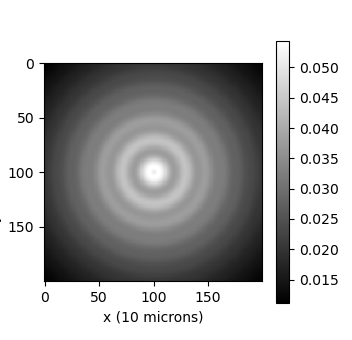

In [4]:
Airy_transverse_map(0.38)

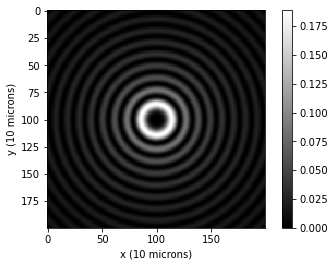

In [28]:
Bessel_transverse_map(0.38)

# Quick Airy propagation plot (z- and r-dependence) (to obtain $z_f$)

z_f =  0.38418 m


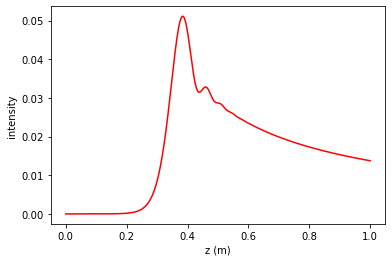

In [320]:
zmin, zmax, dz = 0.0, 1.0, 10**-5
zlist = np.arange(zmin, zmax, dz)
intensity = [np.real(airy(0,0,z))**2 + np.imag(airy(0,0,z))**2 for z in zlist]
index = [q for q, value in enumerate(intensity) if value == max(intensity)] 
print('z_f = ', zmin + index[0]*dz, 'm') #0.385 as we improve resolution
plt.plot(zlist, intensity, 'r-')
plt.xlabel('z (m)')
plt.ylabel('intensity')
plt.show()

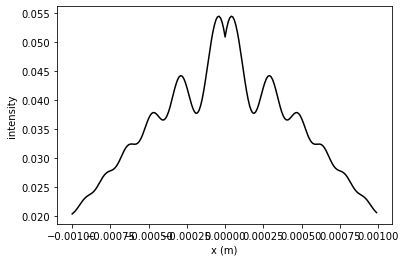

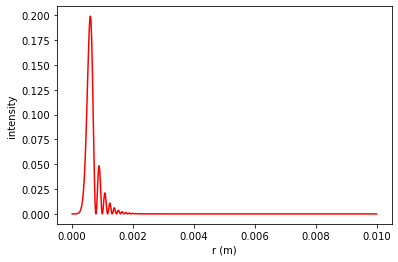

In [392]:
zf = 0.0
rmin, rmax, dr = 0.0, 10**-2, 10**-5
xmax, dx = 10**-3, 10**-5
rlist = np.arange(rmin, rmax, dr)
intensity_x_list, intensity_r_list = [], []
for r in rlist:
    x0 = (r_0 - r)/s
    xi = zf/(k_0 * s**2)
    g = sp.airy(x0 - (xi**2)/4 + 1j*a*xi)[0] * np.exp(a*x0 - a*(xi**2)/2) * np.exp(1j*(x0*xi/2 + a**2*(xi)/2 - xi**3/12))
    u_CAB = C * g * np.exp(1j*k_0*zf)
    intensity_r_list.append(np.real(u_CAB)**2 + np.imag(u_CAB)**2)
xlist = np.arange(-xmax, xmax, dx)
for x in xlist:
    u_CAB = airy(x, 0.0, 0.38)
    intensity_x_list.append(np.real(u_CAB)**2 + np.imag(u_CAB)**2)
plt.plot(xlist, intensity_x_list, 'k-')
plt.xlabel('x (m)')
plt.ylabel('intensity')
plt.show()
plt.plot(rlist, intensity_r_list, 'r-')
plt.xlabel('r (m)')
plt.ylabel('intensity')
plt.show()

# $J_{l}$ behavior (to obtain $r_b$)

x_b =  1.7715674231034393


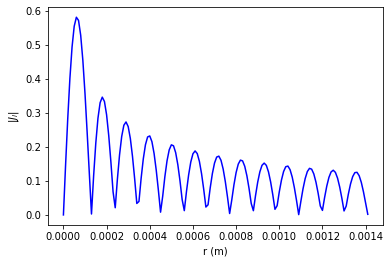

In [350]:
l = 1
theta = 5*10**-3
jl_list = []
rmin, rmax, dr = 0.0, np.sqrt(2)*10**-3, 10**-5
rlist = np.arange(rmin, rmax, dr)
jl_list = [abs(sp.jv(l, k_0*np.sin(theta) * r)) for r in rlist]
index = [q for q, value in enumerate(jl_list) if value == max(jl_list)] 
print('x_b = ', (rmin + index[0]*dr)*k_0*np.sin(theta)) #x_b = r_b*k_0*sin(theta)
plt.plot(rlist, jl_list, 'b-')
plt.xlabel('r (m)')
plt.ylabel('$|J_{l}|$')
plt.show()

# x-z braiding:

#### Arguments are: y, A (bessel beam power, typically 1), theta (5$\times$10$^{-3}$) used by experimenters), TC (typically 2)

<IPython.core.display.Javascript object>


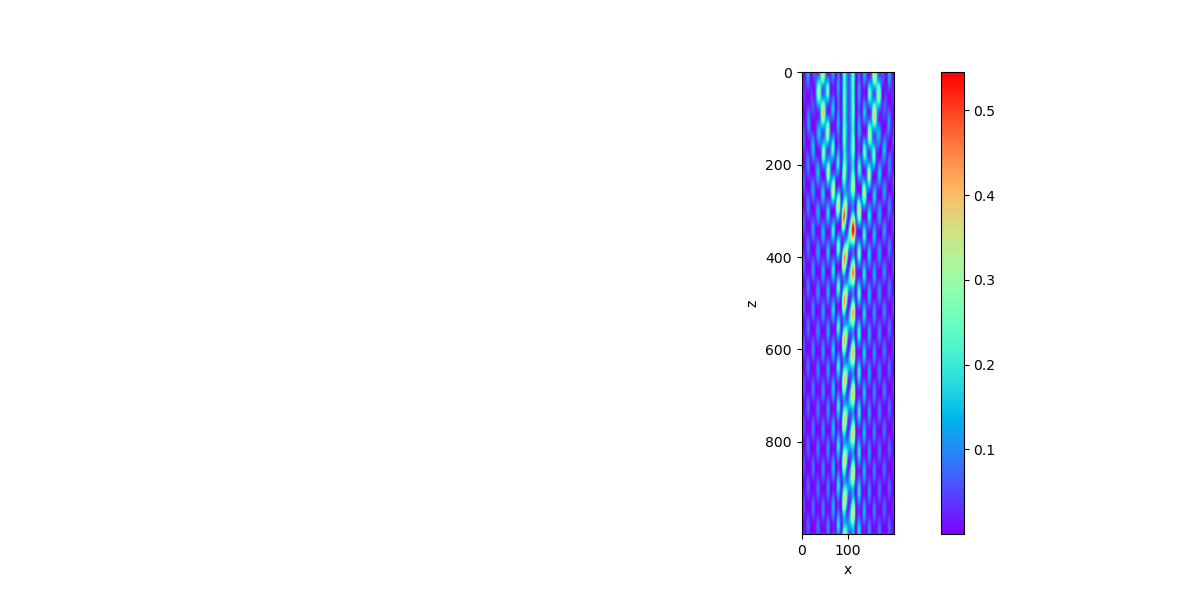

In [50]:
x_z_braiding(0.05*10**-3, 1, 0.005, 2)

#### make a 3D visualization plot:

<IPython.core.display.Javascript object>


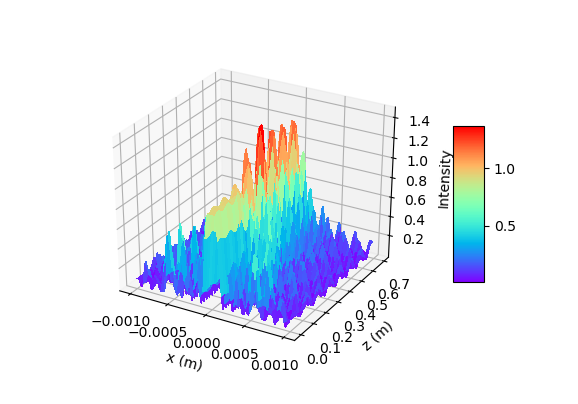

In [104]:
x_z_braiding_3D(0.1*10**-3, 2.0, 0.005, 2)

# x-y plots, with l=2 (before and after braiding)

#### Arguments are: z, A (bessel beam power, typically 1), theta (5$\times$10$^{-3}$) used by experimenters), TC (typically 2)

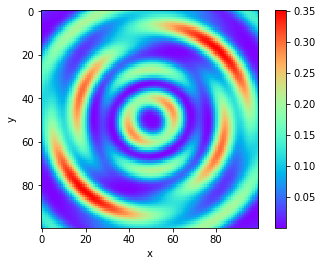

In [397]:
x_y_map(0.2, 1, 5*10**-3, 2)

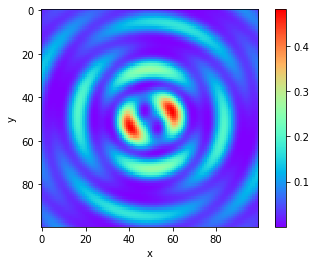

In [398]:
x_y_map(0.386, 1, 5*10**-3, 2)

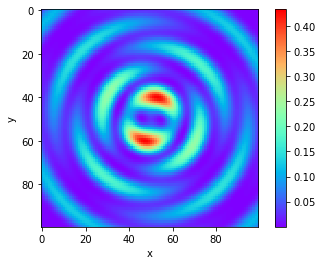

In [399]:
x_y_map(0.5, 1, 5*10**-3, 2)

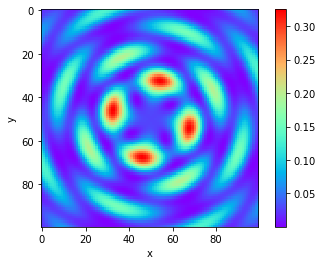

In [404]:
x_y_map(0.5, 1, 5*10**-3, 4)

<IPython.core.display.Javascript object>


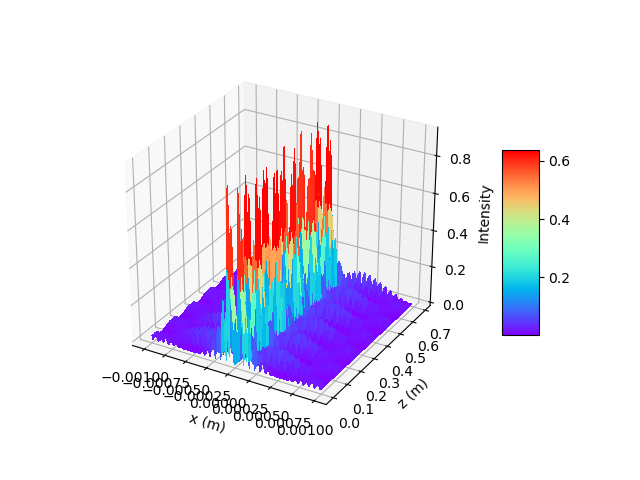

In [192]:
Bessel_sup_3D_map(0.000, 2, -2)